In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("teen_phone_addiction_dataset_noisy.csv")

print(df.shape)
print(df.describe(include="all").T.head(10))

(3000, 25)
                       count unique            top  freq       mean  \
ID                    3000.0    NaN            NaN   NaN     1500.5   
Name                    3000   2682  Richard Smith     4        NaN   
Age                   3000.0    NaN            NaN   NaN  16.094612   
Gender                  3000      3           Male  1031        NaN   
Location                2910   2460  North Michael     6        NaN   
School_Grade            3000      6           12th   525        NaN   
Daily_Usage_Hours     3000.0    NaN            NaN   NaN    5.10621   
Sleep_Hours           3000.0    NaN            NaN   NaN   6.542057   
Academic_Performance  3000.0    NaN            NaN   NaN  75.445682   
Social_Interactions   3000.0    NaN            NaN   NaN   5.199752   

                             std   min        25%        50%       75%  \
ID                    866.169729   1.0     750.75     1500.5   2250.25   
Name                         NaN   NaN        NaN        Na

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      3000 non-null   int64  
 1   Name                    3000 non-null   object 
 2   Age                     3000 non-null   float64
 3   Gender                  3000 non-null   object 
 4   Location                2910 non-null   object 
 5   School_Grade            3000 non-null   object 
 6   Daily_Usage_Hours       3000 non-null   float64
 7   Sleep_Hours             3000 non-null   float64
 8   Academic_Performance    3000 non-null   float64
 9   Social_Interactions     3000 non-null   float64
 10  Exercise_Hours          3000 non-null   float64
 11  Anxiety_Level           3000 non-null   float64
 12  Depression_Level        3000 non-null   float64
 13  Self_Esteem             2910 non-null   float64
 14  Parental_Control        3000 non-null   

In [4]:
# Strip spaces from string/object columns
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = df[c].astype(str).str.strip()

# ---------- Step 2: Handle Gender ----------
# ---- Gender (Nominal → Label Encoding: Male=0, Female=1, Other=2) ----
df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1, 'Other': 2})

# ---------- Step 3: Handle School_Grade ----------
# Ordinal mapping (7th → 7, ..., 12th → 12)
grade_map = {'7th':7, '8th':8, '9th':9, '10th':10, '11th':11, '12th':12}
df['School_Grade'] = df['School_Grade'].map(grade_map)

# ---------- Step 4: Handle Phone_Usage_Purpose ----------
# Nominal variable → One-hot encoding
df = pd.get_dummies(df, columns=['Phone_Usage_Purpose'], drop_first=True)

# ---------- Step 5: Handle Name ----------
# Too unique → Drop it
df = df.drop(columns=['Name', 'ID', 'Location'])

# ---------- Step 6: Summary ----------
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               3000 non-null   float64
 1   Gender                            3000 non-null   int64  
 2   School_Grade                      3000 non-null   int64  
 3   Daily_Usage_Hours                 3000 non-null   float64
 4   Sleep_Hours                       3000 non-null   float64
 5   Academic_Performance              3000 non-null   float64
 6   Social_Interactions               3000 non-null   float64
 7   Exercise_Hours                    3000 non-null   float64
 8   Anxiety_Level                     3000 non-null   float64
 9   Depression_Level                  3000 non-null   float64
 10  Self_Esteem                       2910 non-null   float64
 11  Parental_Control                  3000 non-null   float64
 12  Screen

C:\Users\deogh\AppData\Local\Temp\ipykernel_24452\3717837967.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1, 'Other': 2})


In [5]:
df.isnull().sum()

Age                                  0
Gender                               0
School_Grade                         0
Daily_Usage_Hours                    0
Sleep_Hours                          0
Academic_Performance                 0
Social_Interactions                  0
Exercise_Hours                       0
Anxiety_Level                        0
Depression_Level                     0
Self_Esteem                         90
Parental_Control                     0
Screen_Time_Before_Bed               0
Phone_Checks_Per_Day                 0
Apps_Used_Daily                      0
Time_on_Social_Media                 0
Time_on_Gaming                       0
Time_on_Education                   90
Family_Communication                90
Weekend_Usage_Hours                  0
Addiction_Level                     90
Phone_Usage_Purpose_Education        0
Phone_Usage_Purpose_Gaming           0
Phone_Usage_Purpose_Other            0
Phone_Usage_Purpose_Social Media     0
dtype: int64

<Axes: >

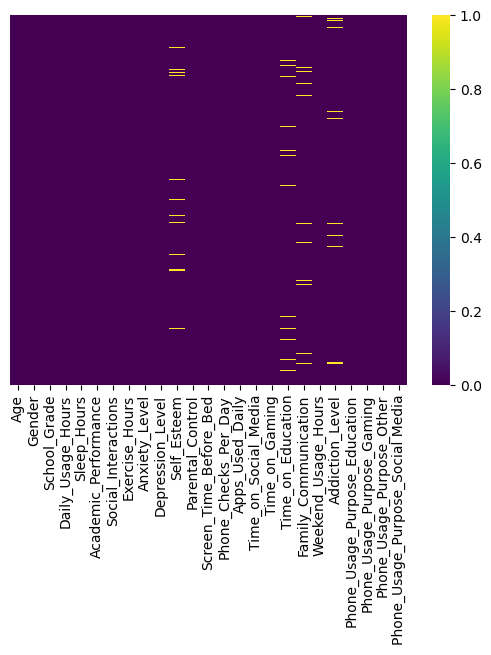

In [6]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=True,cmap='viridis')

                       count unique  top freq       mean        std   min  \
Age                   2910.0    NaN  NaN  NaN  16.090184   2.330014  13.0   
Gender                2910.0    NaN  NaN  NaN   0.979725   0.817858   0.0   
School_Grade          2910.0    NaN  NaN  NaN   9.512715   1.710485   7.0   
Daily_Usage_Hours     2910.0    NaN  NaN  NaN   5.092632   2.168558   0.0   
Sleep_Hours           2910.0    NaN  NaN  NaN   6.537149   1.576598   3.0   
Academic_Performance  2910.0    NaN  NaN  NaN  75.336188  15.519991  50.0   
Social_Interactions   2910.0    NaN  NaN  NaN   5.186898    3.46078   0.0   
Exercise_Hours        2910.0    NaN  NaN  NaN   1.048407    0.73963   0.0   
Anxiety_Level         2910.0    NaN  NaN  NaN    5.64154   3.027854   1.0   
Depression_Level      2910.0    NaN  NaN  NaN   5.504232   2.986849   1.0   

                           25%        50%        75%         max  
Age                   14.06441  15.997322  17.932079   33.805617  
Gender            

<Axes: >

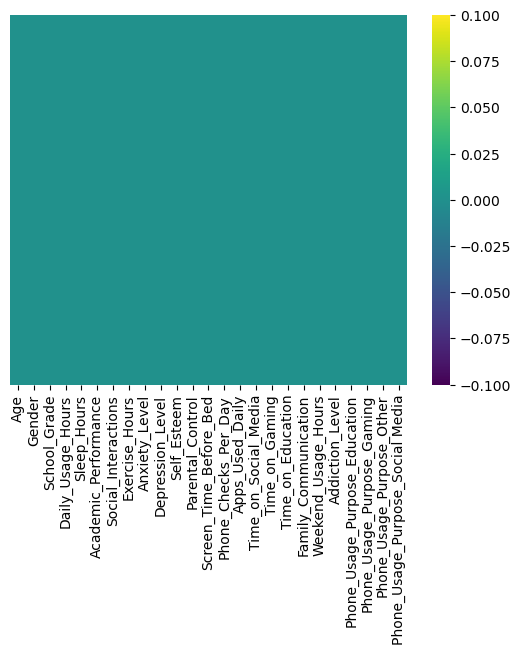

In [7]:
# ---------- Handle missing values ----------

# Drop missing target values (Addiction_Level)
df = df.dropna(subset=['Addiction_Level'])

# Impute numerical features (with mean ± std random values)
num_cols = ['Self_Esteem', 'Time_on_Education', 'Family_Communication']

for col in num_cols:
    avg = df[col].mean()
    std = df[col].std()
    count = df[col].isnull().sum()
    if count > 0:
        random = np.random.uniform(avg - std, avg + std, size=count)
        df.loc[df[col].isnull(), col] = random

# Visualize nulls after imputation
print(df.describe(include="all").T.head(10))
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')



In [8]:
import tabulate
def mad_outlier_caps(df, cols, k=3.5):
    summary = {}
    df_out = df.copy()
    for c in cols:
        x = df_out[c].values.astype(float)
        med = np.nanmedian(x)
        mad = np.nanmedian(np.abs(x - med)) + 1e-9
        lower = med - k * 1.4826 * mad
        upper = med + k * 1.4826 * mad
        
        # Count outliers
        outliers = ((x < lower) | (x > upper)).sum()
        summary[c] = {
            "median": med,
            "mad": mad,
            "lower_cap": lower,
            "upper_cap": upper,
            "outliers_detected": int(outliers)
        }
        
        # Winsorize
        df_out[c] = np.clip(x, lower, upper)
    return df_out, pd.DataFrame(summary).T
  
cols_to_check = [
    "Daily_Usage_Hours", "Sleep_Hours", "Apps_Used_Daily", 
    "Time_on_Social_Media", "Time_on_Gaming", "Phone_Checks_Per_Day"
]

df_winsor, outlier_summary = mad_outlier_caps(df, cols_to_check)

print(tabulate.tabulate(outlier_summary, headers="keys", tablefmt="pretty"))


+----------------------+--------------------+--------------------+---------------------+--------------------+-------------------+
|                      |       median       |        mad         |      lower_cap      |     upper_cap      | outliers_detected |
+----------------------+--------------------+--------------------+---------------------+--------------------+-------------------+
|  Daily_Usage_Hours   | 4.998915437929382  | 1.355409557915019  | -2.034440299047443  | 12.032271174906207 |       19.0        |
|     Sleep_Hours      | 6.506403583371894  | 1.0228825431766864 | 1.1985637785737504  | 11.814243388170038 |       13.0        |
|   Apps_Used_Daily    |        13.0        |    4.000000001     |  -7.7564000051891   |  33.7564000051891  |        5.0        |
| Time_on_Social_Media | 2.5124615040954756 | 0.6784588809317625 | -1.0081294749475331 | 6.033052483138484  |        8.0        |
|    Time_on_Gaming    | 1.5036165743933985 | 0.674604615441002  | -1.996974235591505  | 5

In [9]:
import pandas as pd
import numpy as np
import tabulate

def cap_outliers_mad(df, cols, k=3.5):
    """
    Identifies outliers using the MAD method and caps them at the upper/lower bounds.
    This process is also known as Winsorization.
    """
    summary = {}
    df_capped = df.copy()

    for c in cols:
        # Ensure column is numeric
        x = df_capped[c].astype(float)
        
        # Calculate median and MAD
        median = np.nanmedian(x)
        # Add a small epsilon to avoid division by zero if MAD is 0
        mad = np.nanmedian(np.abs(x - median)) + 1e-9 
        
        # Calculate the robust z-score and the upper/lower bounds
        # The constant 1.4826 makes MAD comparable to the standard deviation
        lower_bound = median - k * 1.4826 * mad
        upper_bound = median + k * 1.4826 * mad
        
        # Count outliers
        outliers_count = ((x < lower_bound) | (x > upper_bound)).sum()
        
        # Store summary statistics
        summary[c] = {
            "median": median,
            "mad": mad,
            "lower_cap": lower_bound,
            "upper_cap": upper_bound,
            "outliers_capped": int(outliers_count)
        }
        
        # Cap the outliers using np.clip
        df_capped[c] = np.clip(x, lower_bound, upper_bound)
        
    summary_df = pd.DataFrame(summary).T
    return df_capped, summary_df

# Features to check
features_to_cap = [
    "Daily_Usage_Hours",
    "Apps_Used_Daily",
    "Time_on_Social_Media",
    "Time_on_Gaming",
    "Phone_Checks_Per_Day",
    "Academic_Performance"
]

# Apply the capping function
df_capped, cap_summary = cap_outliers_mad(df, features_to_cap)

# Show summary table
print("Outlier Capping Summary (MAD method):")
print(tabulate.tabulate(cap_summary, headers="keys", tablefmt="pretty"))

# You can now use df_capped for your next steps

Outlier Capping Summary (MAD method):
+----------------------+--------------------+--------------------+---------------------+--------------------+-----------------+
|                      |       median       |        mad         |      lower_cap      |     upper_cap      | outliers_capped |
+----------------------+--------------------+--------------------+---------------------+--------------------+-----------------+
|  Daily_Usage_Hours   | 4.998915437929382  | 1.355409557915019  | -2.034440299047443  | 12.032271174906207 |      19.0       |
|   Apps_Used_Daily    |        13.0        |    4.000000001     |  -7.7564000051891   |  33.7564000051891  |       5.0       |
| Time_on_Social_Media | 2.5124615040954756 | 0.6784588809317625 | -1.0081294749475331 | 6.033052483138484  |       8.0       |
|    Time_on_Gaming    | 1.5036165743933985 | 0.674604615441002  | -1.996974235591505  | 5.004207384378302  |       7.0       |
| Phone_Checks_Per_Day |        82.0        |    32.000000001    |

In [10]:
# Select only numerical columns for outlier treatment
numerical_cols = df.select_dtypes(include=np.number).columns

# Cap outliers using the IQR method
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap the outliers
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])

# Check the result - notice the 'max' values are now more reasonable
print("Descriptive statistics after handling outliers:")
print(df.describe())

Descriptive statistics after handling outliers:
               Age       Gender  School_Grade  Daily_Usage_Hours  Sleep_Hours  \
count  2910.000000  2910.000000   2910.000000        2910.000000  2910.000000   
mean     16.045450     0.979725      9.512715           5.053181     6.522554   
std       2.099568     0.817858      1.710485           2.005813     1.518570   
min      13.000000     0.000000      7.000000           0.000000     3.000000   
25%      14.064410     0.000000      8.000000           3.718008     5.487177   
50%      15.997322     1.000000      9.000000           4.998915     6.506404   
75%      17.932079     2.000000     11.000000           6.390097     7.538909   
max      23.733582     2.000000     12.000000          10.398229    10.616506   

       Academic_Performance  Social_Interactions  Exercise_Hours  \
count           2910.000000          2910.000000     2910.000000   
mean              75.256871             5.146091        1.046765   
std               

Correlations with Addiction_Level:
Addiction_Level                     1.000000
Daily_Usage_Hours                   0.566424
Time_on_Social_Media                0.296551
Apps_Used_Daily                     0.294749
Time_on_Gaming                      0.257018
Phone_Checks_Per_Day                0.224207
Phone_Usage_Purpose_Other           0.027246
Age                                 0.019631
Academic_Performance                0.015377
Phone_Usage_Purpose_Gaming          0.013269
Screen_Time_Before_Bed              0.011352
School_Grade                        0.008623
Depression_Level                    0.007866
Anxiety_Level                       0.007107
Family_Communication               -0.002730
Weekend_Usage_Hours                -0.008417
Phone_Usage_Purpose_Education      -0.010380
Gender                             -0.010868
Time_on_Education                  -0.012259
Parental_Control                   -0.013453
Social_Interactions                -0.017029
Phone_Usage_Purpose_

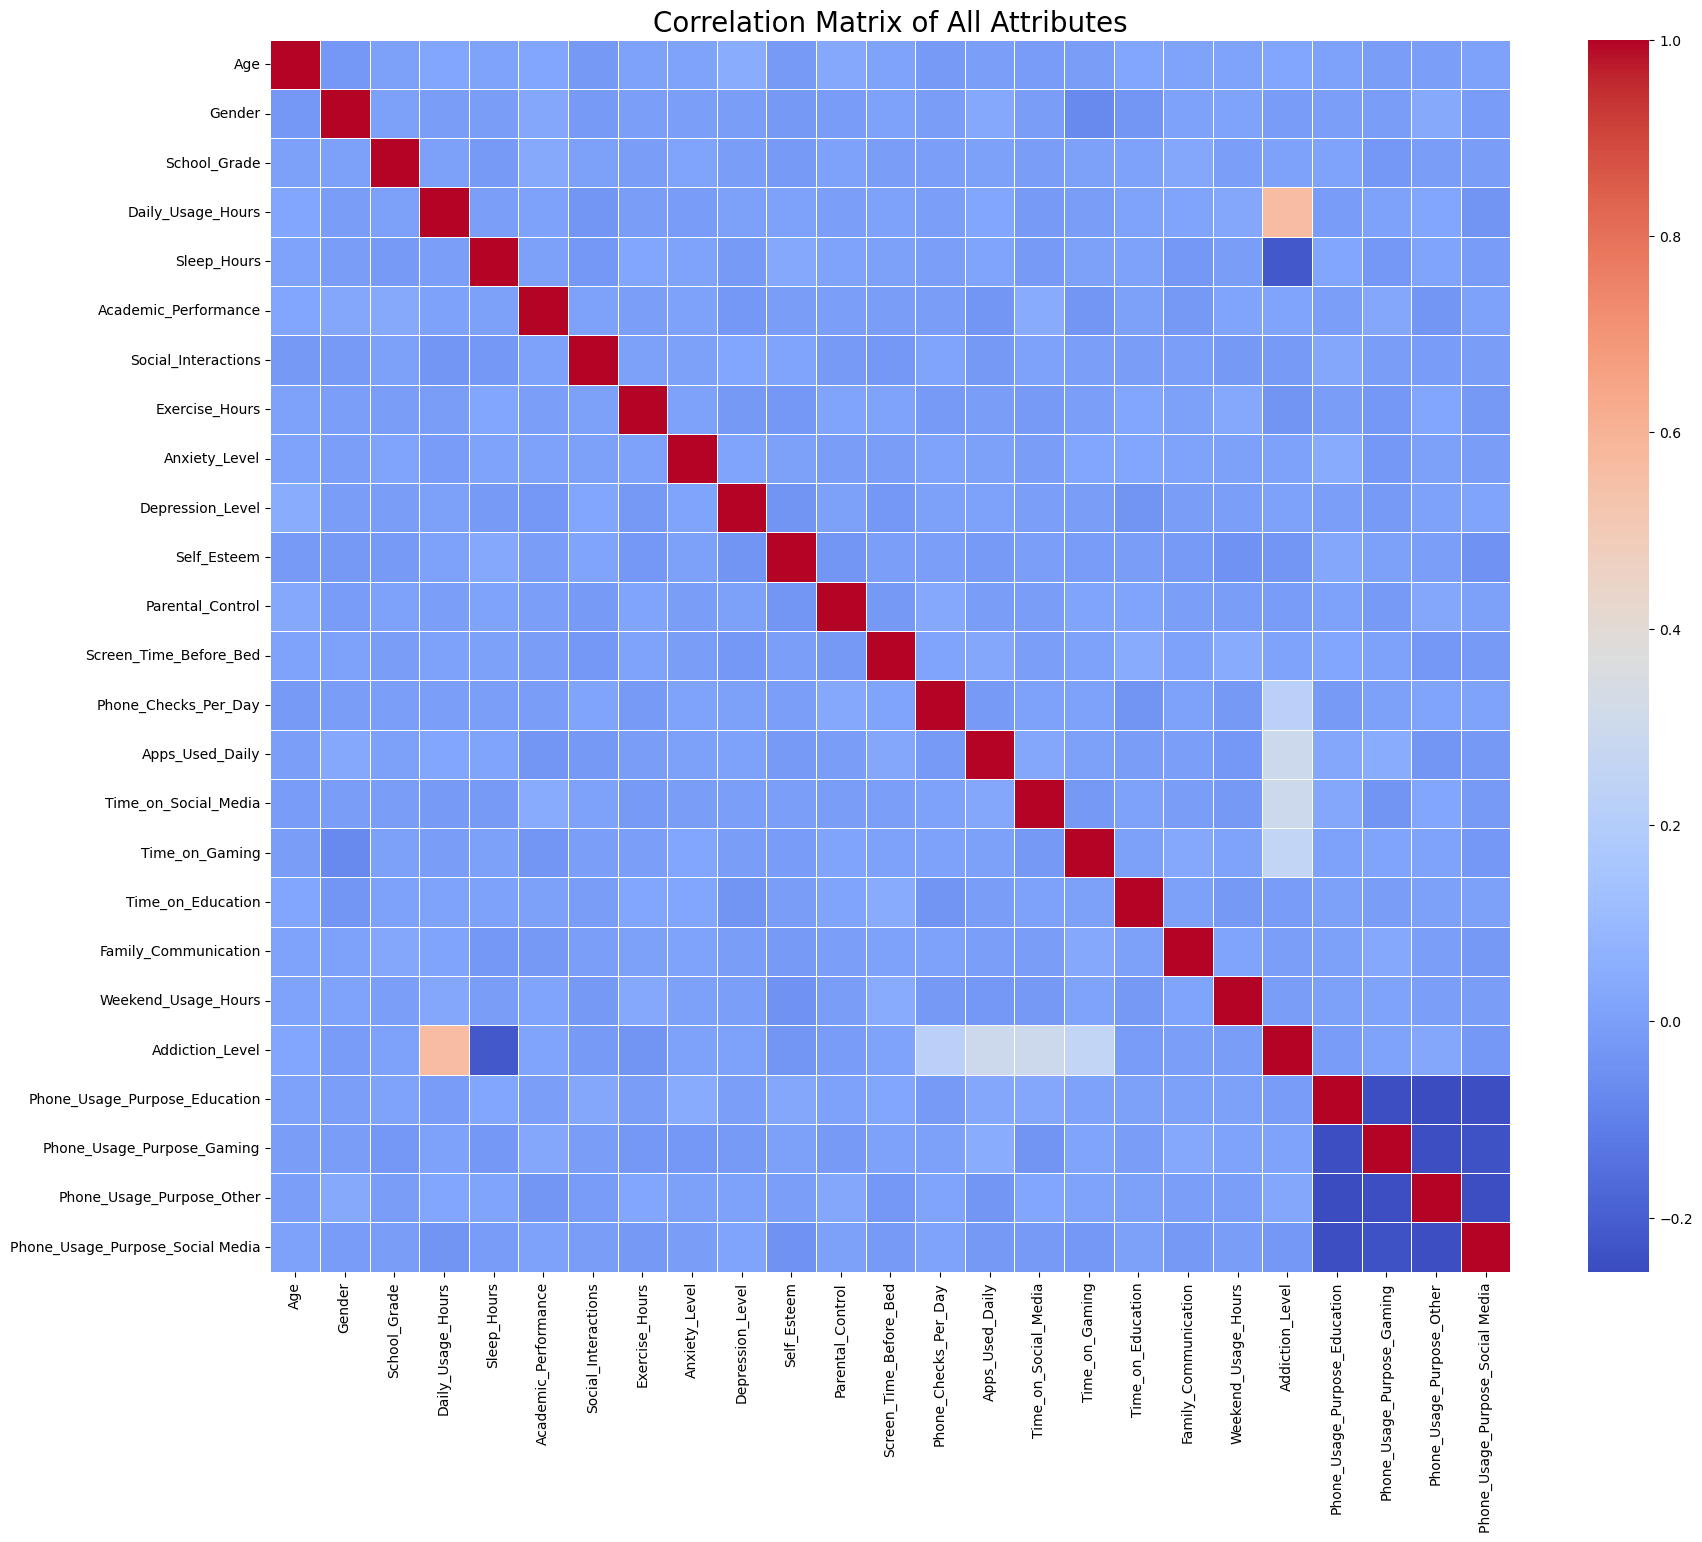

In [11]:
# Now 'df' is fully preprocessed before scaling, which is ideal for correlation analysis.
corr_matrix = df.corr()

# Set up the matplotlib figure for the heatmap
plt.figure(figsize=(20, 16))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of All Attributes', fontsize=20)
plt.savefig('correlation_heatmap.png', bbox_inches='tight')

# Print the correlations specifically with the target variable
addiction_correlations = corr_matrix['Addiction_Level'].sort_values(ascending=False)
print("Correlations with Addiction_Level:")
print(addiction_correlations)

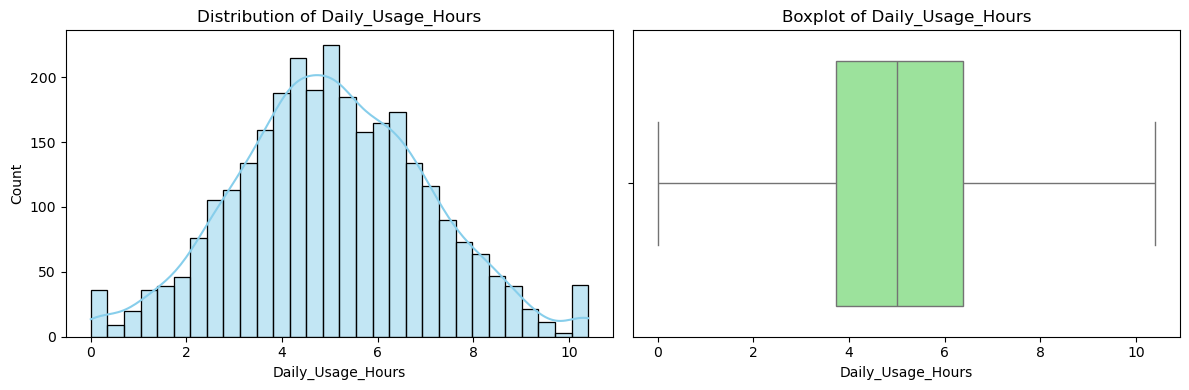

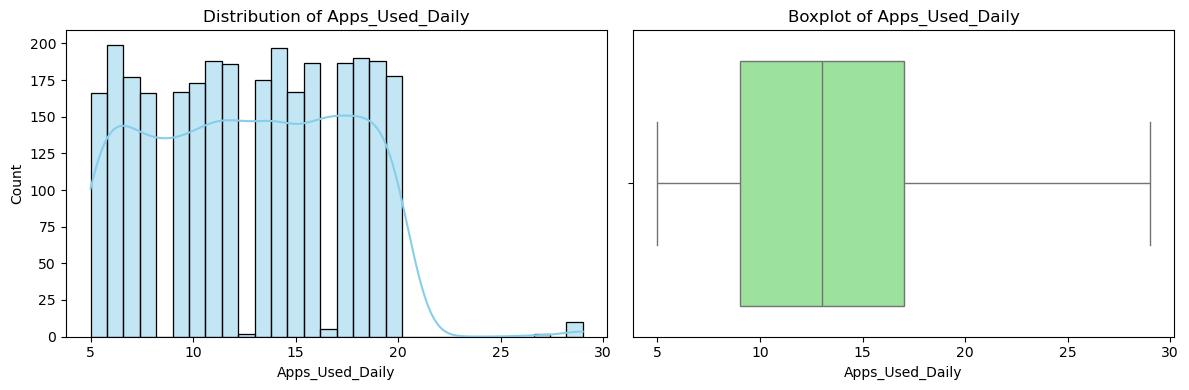

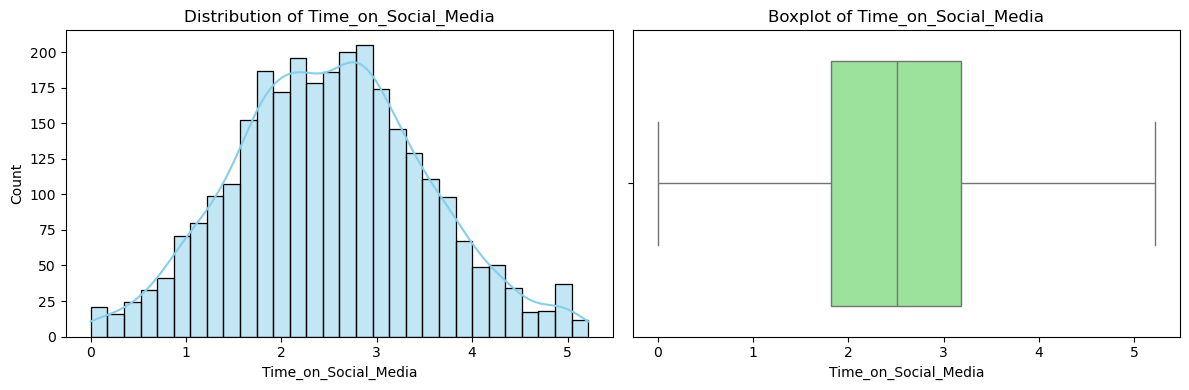

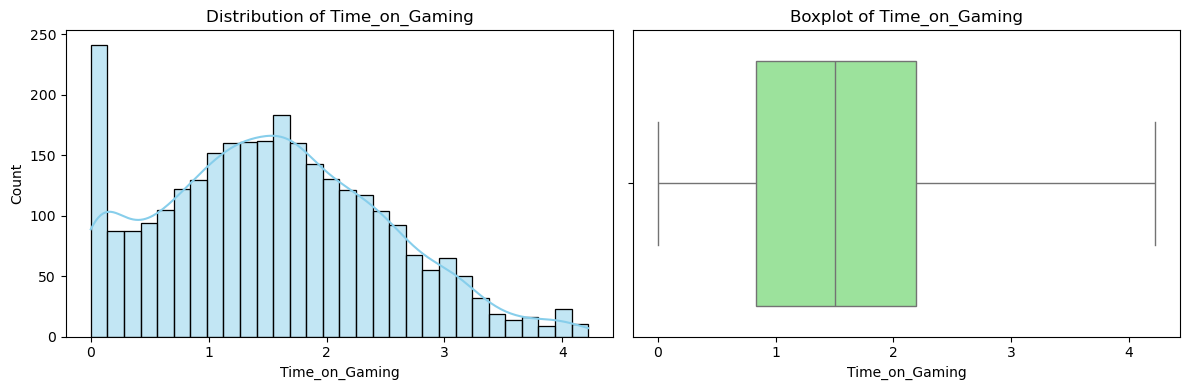

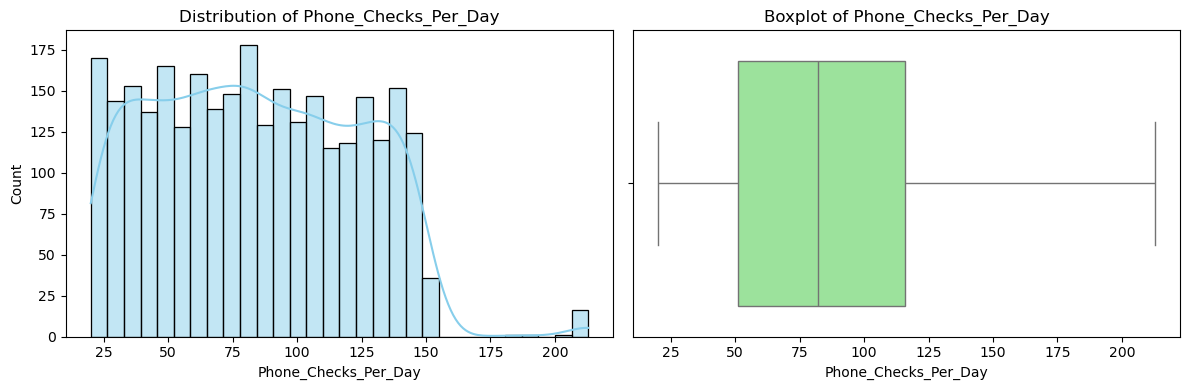

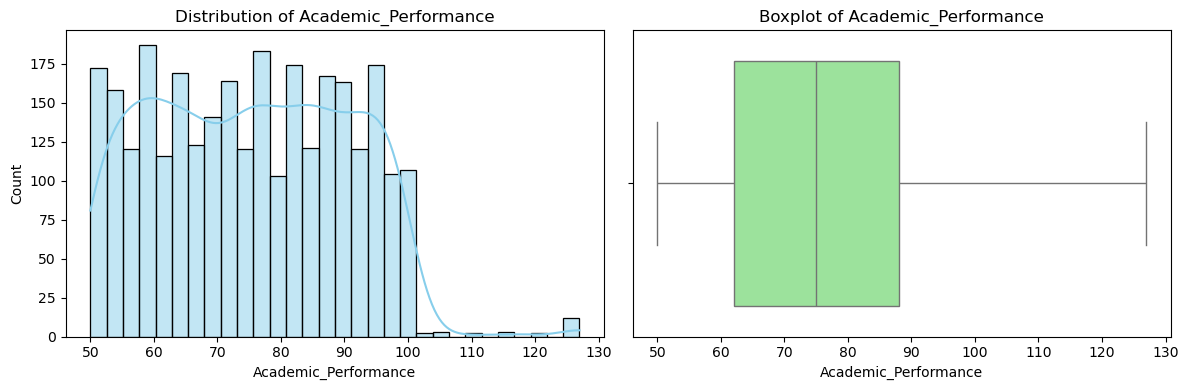

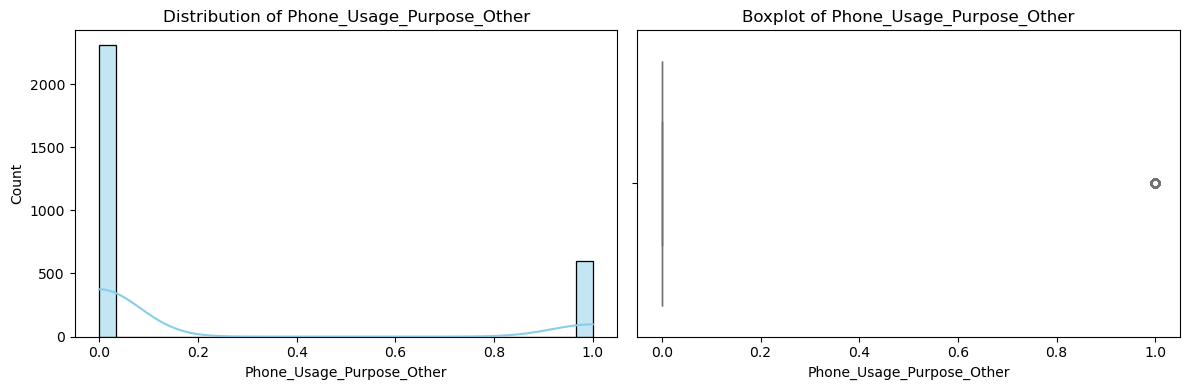

In [12]:
# top 7 Corrected list of features
features = [
    "Daily_Usage_Hours", "Apps_Used_Daily",
    "Time_on_Social_Media", "Time_on_Gaming", "Phone_Checks_Per_Day",
    "Academic_Performance", "Phone_Usage_Purpose_Other"
]

# plot for each feature
for col in features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram + KDE
    sns.histplot(df[col], kde=True, ax=axes[0], bins=30, color="skyblue")
    axes[0].set_title(f"Distribution of {col}")

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1], color="lightgreen")
    axes[1].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

Outlier Handling Summary:
                         median        mad  outliers_handled
Daily_Usage_Hours      4.998915   2.009530               0.0
Apps_Used_Daily       13.000000   5.930400               0.0
Time_on_Social_Media   2.512462   1.005883               0.0
Time_on_Gaming         1.503617   1.000169               0.0
Phone_Checks_Per_Day  82.000000  47.443200               0.0
Academic_Performance  75.000000  19.273800               0.0

--- Visualizing Before vs. After ---


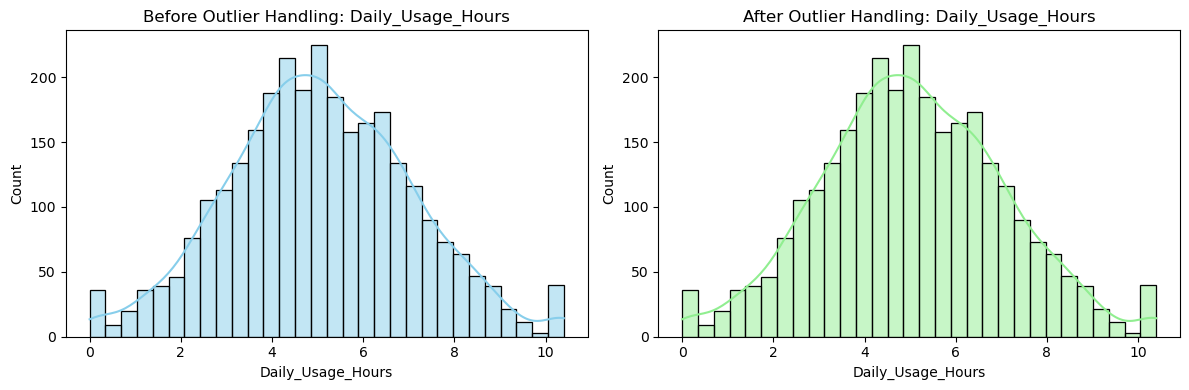

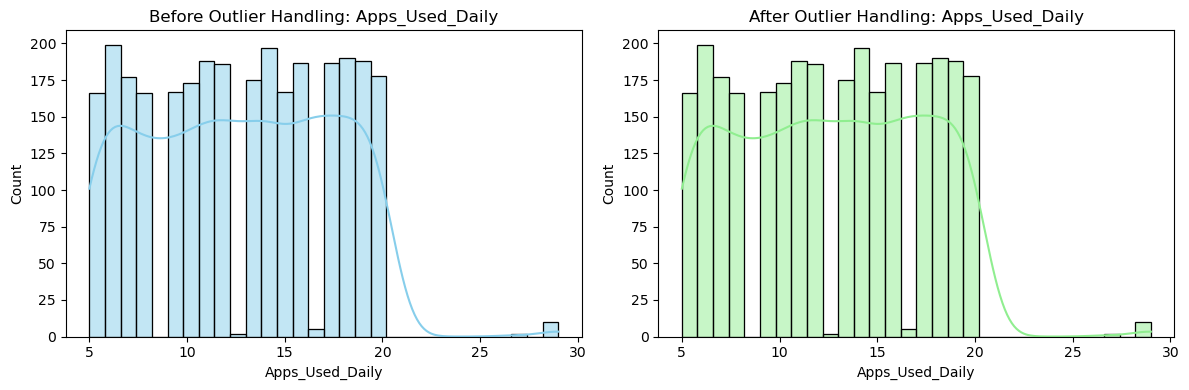

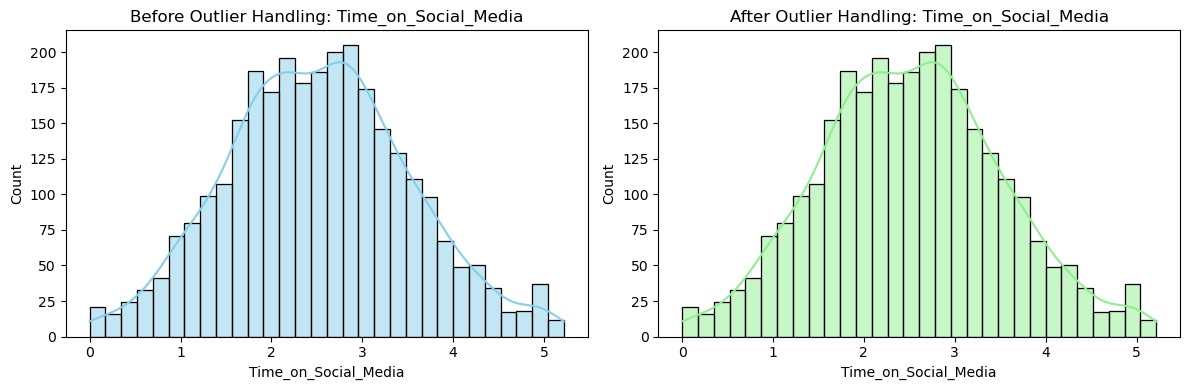

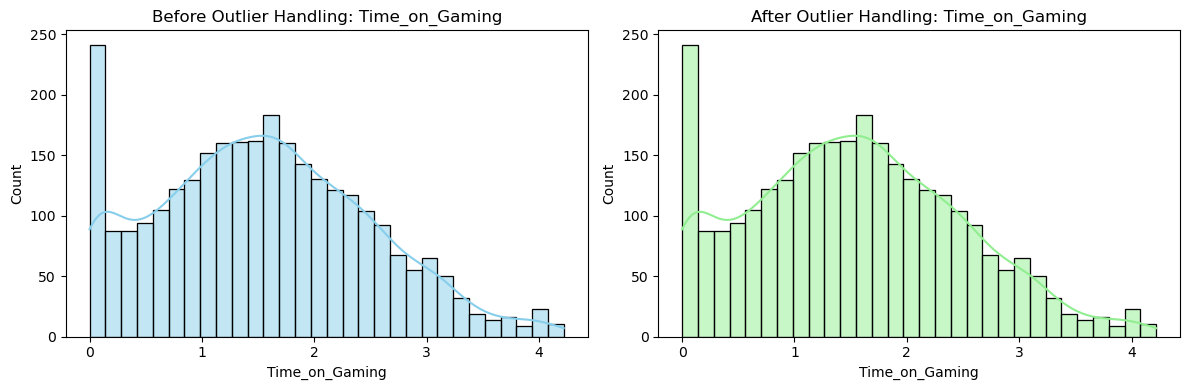

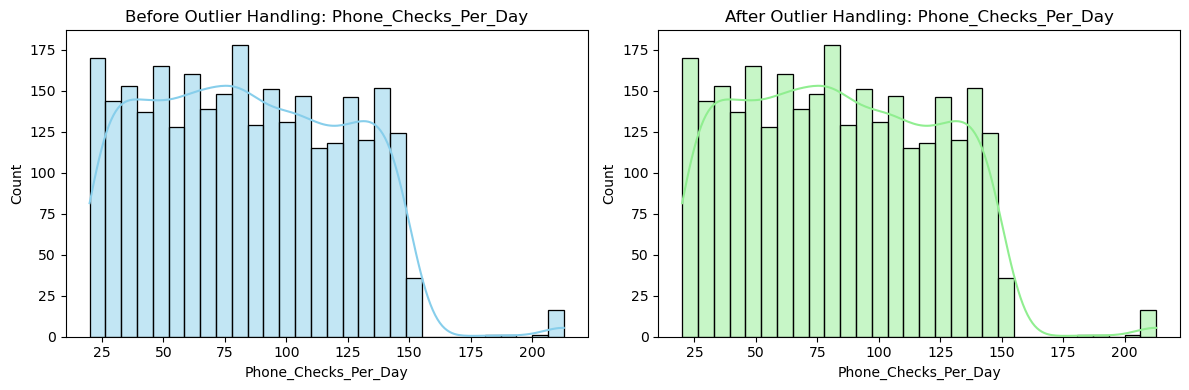

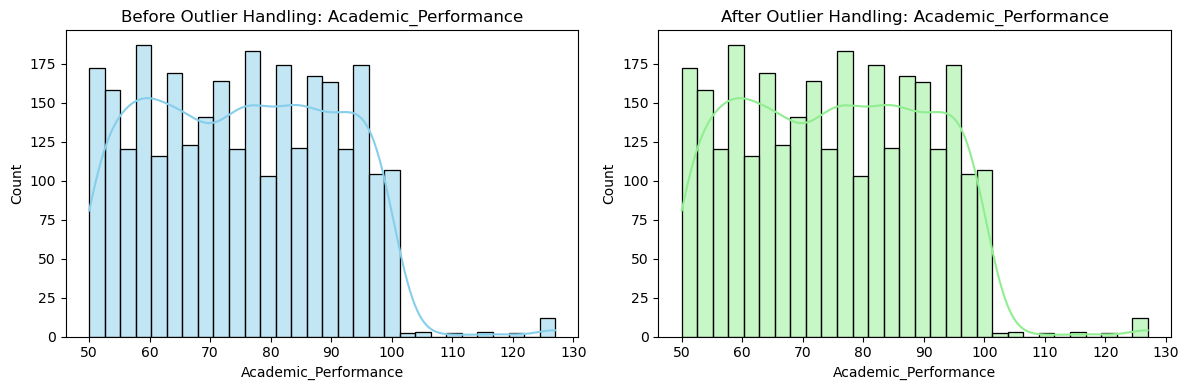

In [13]:
# --- PART 1: The Outlier Handling Function and Call (This creates df_clean) ---

# The full function that returns BOTH the DataFrame and the summary
def handle_outliers_mad(df, cols, k=3.5):
    summary = {}
    df_out = df.copy()
    
    for col in cols:
        med = df_out[col].median()
        mad = 1.4826 * np.median(np.abs(df_out[col] - med))
        
        # Outlier mask
        outlier_mask = np.abs(df_out[col] - med) > (k * mad)
        outlier_count = outlier_mask.sum()
        
        # Replace outliers with median
        df_out.loc[outlier_mask, col] = med
        
        # Save summary
        summary[col] = {
            "median": med,
            "mad": mad,
            "outliers_handled": int(outlier_count)
        }
        
    summary_df = pd.DataFrame(summary).T
    # This return statement is now correct for your call
    return df_out, summary_df

# List of features to clean
features_to_clean = [
    "Daily_Usage_Hours", "Apps_Used_Daily", "Time_on_Social_Media",
    "Time_on_Gaming", "Phone_Checks_Per_Day", "Academic_Performance"
]

# Apply the function to create df_clean
# This call now works because the function returns two items
df_clean, mad_summary = handle_outliers_mad(df, features_to_clean)
print("Outlier Handling Summary:")
print(mad_summary)


# --- PART 2: Your Visualization Code (This will now run without error) ---
print("\n--- Visualizing Before vs. After ---")

for col in features_to_clean:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Before cleaning
    sns.histplot(df[col], kde=True, bins=30, color="skyblue", ax=axes[0])
    axes[0].set_title(f"Before Outlier Handling: {col}")

    # After cleaning
    sns.histplot(df_clean[col], kde=True, bins=30, color="lightgreen", ax=axes[1])
    axes[1].set_title(f"After Outlier Handling: {col}")

    plt.tight_layout()
    plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler  # <-- Important: Import the scaler
from sklearn.metrics import mean_squared_error, r2_score

# --- Step 1: Use the CLEANED data ---
# This is the most important change!
X = df_clean.drop("Addiction_Level", axis=1)
y = df_clean["Addiction_Level"]

# --- Step 2: Scale the Features ---
# This ensures all features are on a level playing field
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 3: Train-Test Split ---
# We use the SCALED data now
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42
)

# --- Step 4: Train the Model ---
rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1  # Uses all available CPU cores to speed up training
)
rf_reg.fit(X_train, y_train)

# --- Step 5: Make Predictions and Evaluate ---
y_pred = rf_reg.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("✅ Random Forest Regressor implemented successfully!")
print(f"RMSE (Root Mean Squared Error): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

✅ Random Forest Regressor implemented successfully!
RMSE (Root Mean Squared Error): 0.803
R² Score: 0.729


📌 Top 10 Features Influencing Addiction Level:
                   Feature  Importance
3        Daily_Usage_Hours    0.404634
15    Time_on_Social_Media    0.132426
16          Time_on_Gaming    0.108974
14         Apps_Used_Daily    0.107058
13    Phone_Checks_Per_Day    0.069288
4              Sleep_Hours    0.067461
17       Time_on_Education    0.015465
12  Screen_Time_Before_Bed    0.010560
7           Exercise_Hours    0.010516
19     Weekend_Usage_Hours    0.010125


C:\Users\deogh\AppData\Local\Temp\ipykernel_24452\1958310101.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp.head(10), x="Importance", y="Feature", palette="viridis")


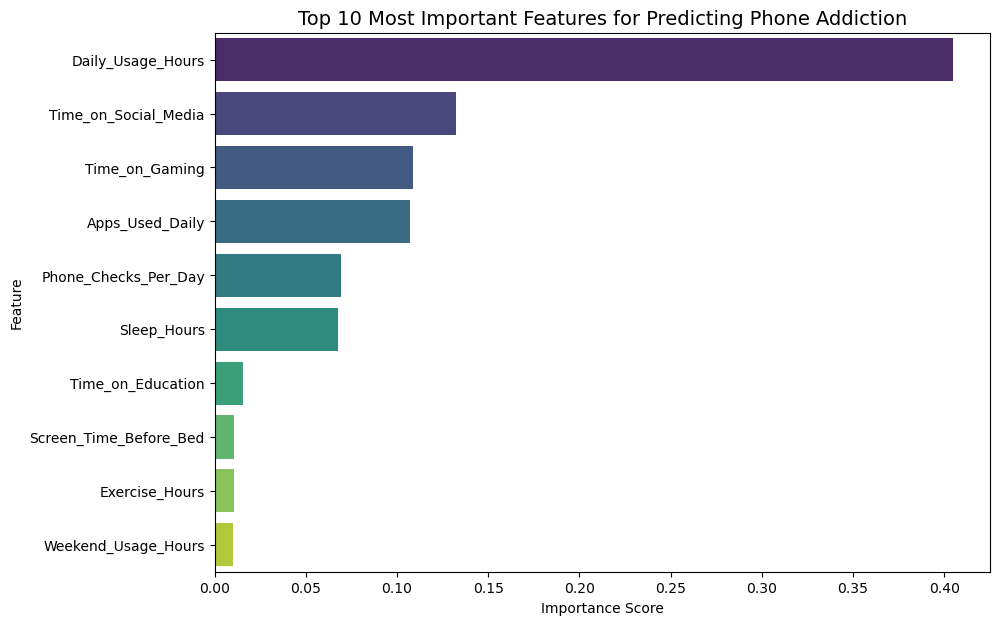

In [15]:
# --- Feature Importance Extraction ---
# Get the importance scores from the trained model
importances = rf_reg.feature_importances_

# Create a DataFrame to view the feature importances clearly
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values("Importance", ascending=False) # Sort to find the most important features

print("📌 Top 10 Features Influencing Addiction Level:")
print(feat_imp.head(10))

# --- Visualization ---
# Create the bar plot to visualize the top features
plt.figure(figsize=(10, 7)) # Made the plot a bit bigger for clarity
sns.barplot(data=feat_imp.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Most Important Features for Predicting Phone Addiction", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [16]:
# === Add train/test flag ===
df["is_train"] = np.random.uniform(0, 1, len(df)) <= 0.75

# === Create train and test sets ===
train, test = df[df["is_train"] == True], df[df["is_train"] == False]

# Use X_test, which was created by train_test_split
print(f"No. of observations in the training dataset: {len(train)}")
# You can also use y_test
print(f"No. of observations in the testing dataset: {len(test)}")
# === Features (excluding target and helper column) ===
f = df.columns.drop(["Addiction_Level", "is_train"])
print("Features used for training:", f.tolist())


No. of observations in the training dataset: 2168
No. of observations in the testing dataset: 742
Features used for training: ['Age', 'Gender', 'School_Grade', 'Daily_Usage_Hours', 'Sleep_Hours', 'Academic_Performance', 'Social_Interactions', 'Exercise_Hours', 'Anxiety_Level', 'Depression_Level', 'Self_Esteem', 'Parental_Control', 'Screen_Time_Before_Bed', 'Phone_Checks_Per_Day', 'Apps_Used_Daily', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education', 'Family_Communication', 'Weekend_Usage_Hours', 'Phone_Usage_Purpose_Education', 'Phone_Usage_Purpose_Gaming', 'Phone_Usage_Purpose_Other', 'Phone_Usage_Purpose_Social Media']


In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# =============================
# Step 1: Use the CLEANED Data and Split It
# =============================
# CRITICAL: Use the df_clean DataFrame from your previous steps
X = df_clean[["Daily_Usage_Hours", "Time_on_Social_Media",
               "Time_on_Gaming", "Apps_Used_Daily", "Phone_Checks_Per_Day",
               "Sleep_Hours"]]
y = df_clean["Addiction_Level"]

# CRITICAL: Split the data BEFORE doing any training or tuning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# =============================
# Step 2: Create a Pipeline
# =============================
# This pipeline will first scale the data, then apply the KNN model
pipe = Pipeline([
    ("standardizer", StandardScaler()),
    ("knn", KNeighborsRegressor()) # We define the model here but tune it below
])

# =============================
# Step 3: Define the Hyperparameter Search Space
# =============================
# We'll search for the best number of neighbors, weighting method, and distance metric
search_space = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]  # 1 = Manhattan distance, 2 = Euclidean distance
}

# =============================
# Step 4: Run the Grid Search on the TRAINING Data
# =============================
# GridSearchCV will find the best combination of parameters using cross-validation
# Importantly, we only fit it on the TRAINING data
grid_search = GridSearchCV(pipe, search_space, cv=5, scoring="r2", verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# =============================
# Step 5: Show the Best Parameters Found
# =============================
print("✅ Grid Search Complete!")
print(f"Best Parameters Found: {grid_search.best_params_}")
print(f"Best Cross-Validation R² Score: {grid_search.best_score_:.3f}")

# =============================
# Step 6: Evaluate the FINAL Model on the TEST Data
# =============================
# Now we use the best model found by the search to make predictions on the UNSEEN test data
best_knn_model = grid_search.best_estimator_
y_pred = best_knn_model.predict(X_test)

# Calculate the final, true performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Final Model Performance on Unseen Test Data ---")
print(f"Final RMSE: {rmse:.3f}")
print(f"Final R² Score: {r2:.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Grid Search Complete!
Best Parameters Found: {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'distance'}
Best Cross-Validation R² Score: 0.822

--- Final Model Performance on Unseen Test Data ---
Final RMSE: 0.719
Final R² Score: 0.782


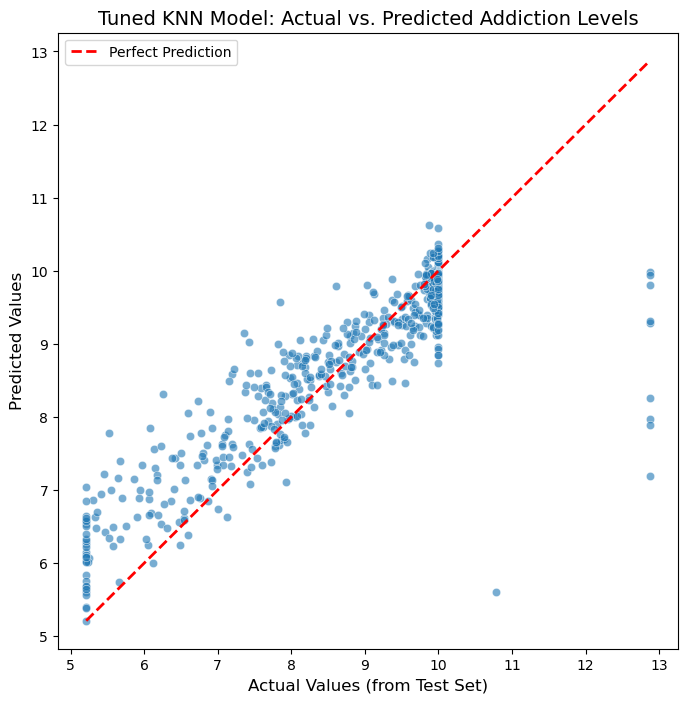

In [18]:
# --- Create the Prediction Error Plot ---

# The variable 'y_pred' was created in the last step by the GridSearchCV model
# The variable 'y_test' was also created in that step during the train_test_split

plt.figure(figsize=(8, 8))

# Corrected line: Use y_pred, which holds your latest KNN predictions
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

# Add a line for perfect predictions (where Actual equals Predicted)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Perfect Prediction')

# Add titles and labels for clarity
plt.title('Tuned KNN Model: Actual vs. Predicted Addiction Levels', fontsize=14)
plt.xlabel('Actual Values (from Test Set)', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend()
plt.show()


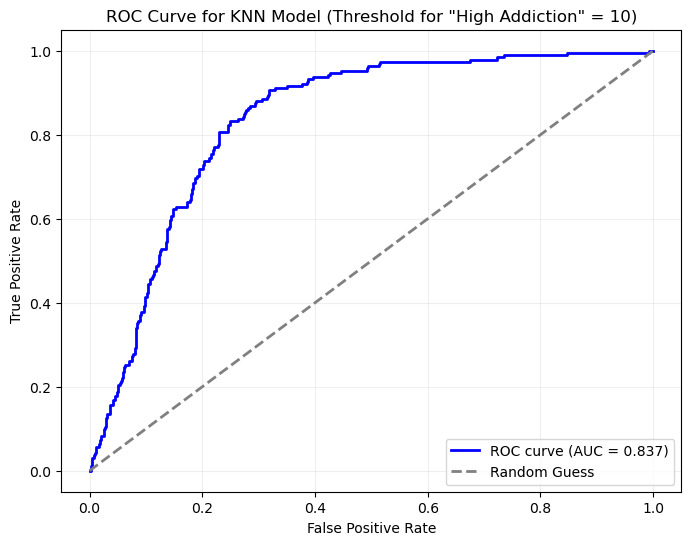

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

# --- Step 1: Define a Binary Classification Problem ---
# We'll set a threshold to create two classes. For example, any user with an
# addiction score of 10 or more will be considered "High Addiction" (Class 1).
threshold = 10

# Convert the actual scores (y_test) into binary classes (0 or 1)
y_test_binary = (y_test >= threshold).astype(int)

# --- Step 2: Get Prediction Scores for the ROC Curve ---
# The ROC curve works best with the raw prediction scores. Since your model
# predicts the addiction level, higher scores indicate a higher chance
# of being in the "High Addiction" class. We can use these directly.
y_pred_scores = y_pred

# --- Step 3: Calculate the ROC Curve and AUC Score ---
# This calculates the points on the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_scores)

# This calculates the Area Under the Curve (a single score for performance)
auc = roc_auc_score(y_test_binary, y_pred_scores)

# --- Step 4: Plot the ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess') # Line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for KNN Model (Threshold for "High Addiction" = {threshold})')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# =============================
# Step 1: Use the CLEANED Data
# =============================
# CRITICAL: Ensure you are using the cleaned DataFrame
X = df_clean.drop("Addiction_Level", axis=1)
y = df_clean["Addiction_Level"]

# =============================
# Step 2: Convert the Target to a Binary Classification
# =============================
# Create two classes: "High Addiction" (1) and "Not High Addiction" (0)
threshold = 10
y_class = (y >= threshold).astype(int)

# Optional: Check if the classes are balanced
print("Class Distribution:")
print(pd.Series(y_class).value_counts())
print("-" * 30)

# =============================
# Step 3: Define the Pipeline
# =============================
# A pipeline ensures the data is scaled correctly during each cross-validation fold
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    # NOTE: We are using a fixed k=10 here. For best results, this should be tuned.
    ("knn", KNeighborsClassifier(n_neighbors=10, metric="euclidean"))
])

# =============================
# Step 4: Perform Cross-Validation
# =============================
# Get robust estimates for recall and precision using 5-fold cross-validation
recall_scores = cross_val_score(pipeline, X, y_class, cv=5, scoring="recall")
precision_scores = cross_val_score(pipeline, X, y_class, cv=5, scoring="precision")

print("✅ Cross-Validation Results (5-fold)")
print(f"Recall:    Mean = {np.mean(recall_scores):.3f} | Scores = {np.round(recall_scores, 3)}")
print(f"Precision: Mean = {np.mean(precision_scores):.3f} | Scores = {np.round(precision_scores, 3)}")

Class Distribution:
Addiction_Level
0    2154
1     756
Name: count, dtype: int64
------------------------------
✅ Cross-Validation Results (5-fold)
Recall:    Mean = 0.074 | Scores = [0.066 0.066 0.079 0.086 0.072]
Precision: Mean = 0.462 | Scores = [0.417 0.435 0.5   0.5   0.458]


In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

print("--- Tuned Decision Tree Model ---")

# Define the hyperparameter search space
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Initialize the Decision Tree Regressor
dt_tuner = DecisionTreeRegressor(random_state=42)

# Set up GridSearchCV to find the best parameters
grid_search_dt = GridSearchCV(estimator=dt_tuner, param_grid=param_grid,
                              cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit the grid search to the training data
# (This assumes X_train and y_train are already created from a previous step)
grid_search_dt.fit(X_train, y_train)

# Get the best model found by the search
best_dt_model = grid_search_dt.best_estimator_

# Make predictions with the best model on the test set
y_pred_best_dt = best_dt_model.predict(X_test)

# Evaluate the tuned model
rmse_best_dt = np.sqrt(mean_squared_error(y_test, y_pred_best_dt))
r2_best_dt = r2_score(y_test, y_pred_best_dt)

print("\n✅ Tuned Decision Tree -> Best Parameters:", grid_search_dt.best_params_)
print(f"✅ Tuned Decision Tree -> RMSE: {rmse_best_dt:.3f}, R² Score: {r2_best_dt:.3f}")

--- Tuned Decision Tree Model ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Tuned Decision Tree -> Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4}
✅ Tuned Decision Tree -> RMSE: 1.022, R² Score: 0.560


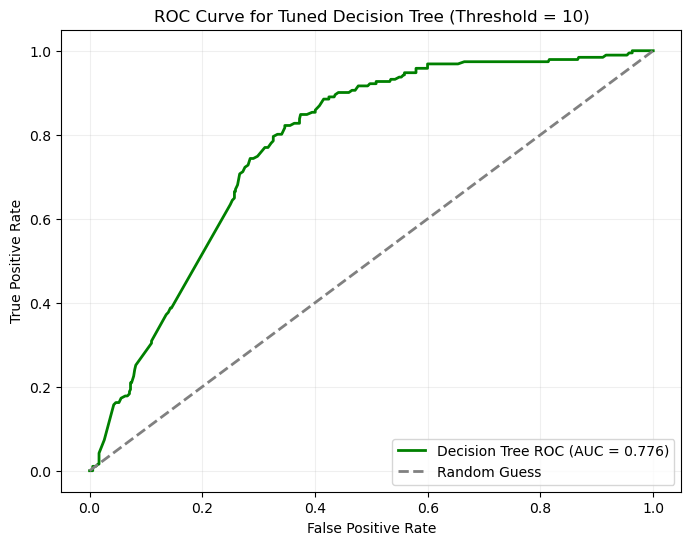

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Step 1: Define the Binary Classification Problem ---
# We use the same threshold to create the classes
threshold = 10
y_test_binary = (y_test >= threshold).astype(int)

# --- Step 2: Get Prediction Scores ---
# Use the prediction scores from the tuned Decision Tree model
y_pred_scores_dt = y_pred_best_dt

# --- Step 3: Calculate ROC and AUC ---
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_scores_dt)
auc = roc_auc_score(y_test_binary, y_pred_scores_dt)

# --- Step 4: Plot the ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'Decision Tree ROC (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Tuned Decision Tree (Threshold = {threshold})')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

--- Logistic Regression Model ---
✅ Accuracy: 0.721

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82       539
           1       0.44      0.28      0.34       189

    accuracy                           0.72       728
   macro avg       0.61      0.58      0.58       728
weighted avg       0.69      0.72      0.70       728


--- Confusion Matrix ---


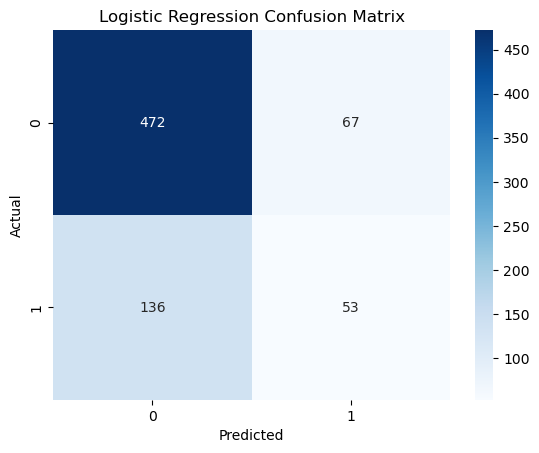

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Step 1: Prepare Data for Classification ---

# Use the final cleaned DataFrame from previous steps
# This assumes 'df_clean' and 'X_scaled' are your fully processed data
X = df_clean.drop("Addiction_Level", axis=1)
y = df_clean["Addiction_Level"]

# Create the binary target variable (y_class)
# We'll define "High Addiction" as any score of 10 or greater
threshold = 10
y_class = (y >= threshold).astype(int) # 1 for High Addiction, 0 for Not

# Split the data into training and testing sets for our classification task
# We use the scaled features and the new y_class
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X_scaled, y_class, test_size=0.25, random_state=42, stratify=y_class
)

# --- Step 2: Implement and Evaluate Logistic Regression ---

print("--- Logistic Regression Model ---")

# Initialize and train the model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train_class)

# Make predictions on the test set
y_pred_log = log_reg.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test_class, y_pred_log)
print(f"✅ Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_log))

# Visualize the Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_class, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

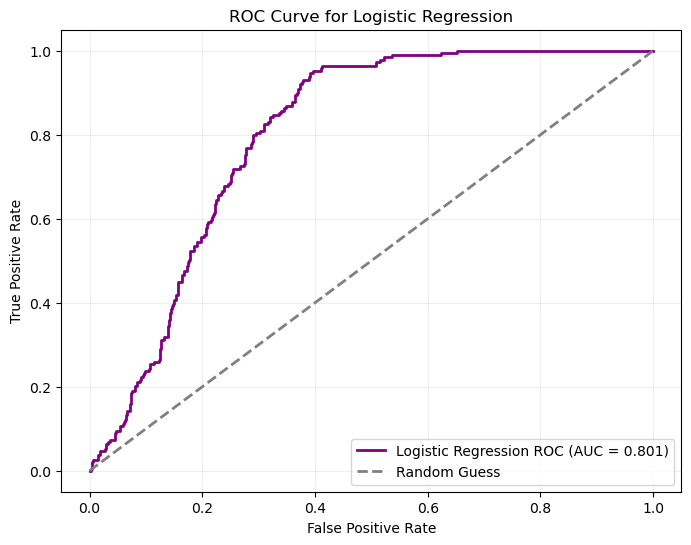

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Step 1: Get Prediction Probabilities ---
# We need the probability of the "positive" class (1, or "High Addiction")
# The .predict_proba() method gives us this. [:, 1] selects the second column.
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# --- Step 2: Calculate ROC and AUC ---
# This calculates the points on the ROC curve
fpr, tpr, _ = roc_curve(y_test_class, y_pred_proba)

# This calculates the Area Under the Curve (a single score for performance)
auc = roc_auc_score(y_test_class, y_pred_proba)

# --- Step 3: Plot the ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'Logistic Regression ROC (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

--- Naive Bayes Model ---
✅ Accuracy: 0.743

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       539
           1       0.51      0.25      0.34       189

    accuracy                           0.74       728
   macro avg       0.64      0.58      0.59       728
weighted avg       0.71      0.74      0.71       728


--- Confusion Matrix ---


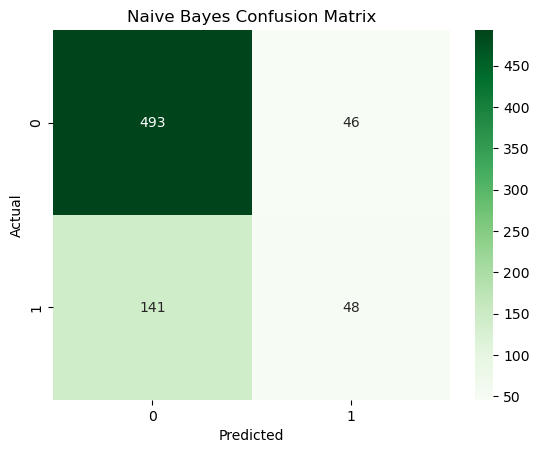

In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("--- Naive Bayes Model ---")

# --- Step 1: Initialize and Train the Model ---
# We use GaussianNB, a version of Naive Bayes suitable for continuous features
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train_class)

# --- Step 2: Make Predictions ---
# Predict the classes for the test set
y_pred_nb = nb_clf.predict(X_test)

# --- Step 3: Evaluate the Model ---
accuracy_nb = accuracy_score(y_test_class, y_pred_nb)
print(f"✅ Accuracy: {accuracy_nb:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_nb))

# --- Step 4: Visualize the Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm_nb = confusion_matrix(y_test_class, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

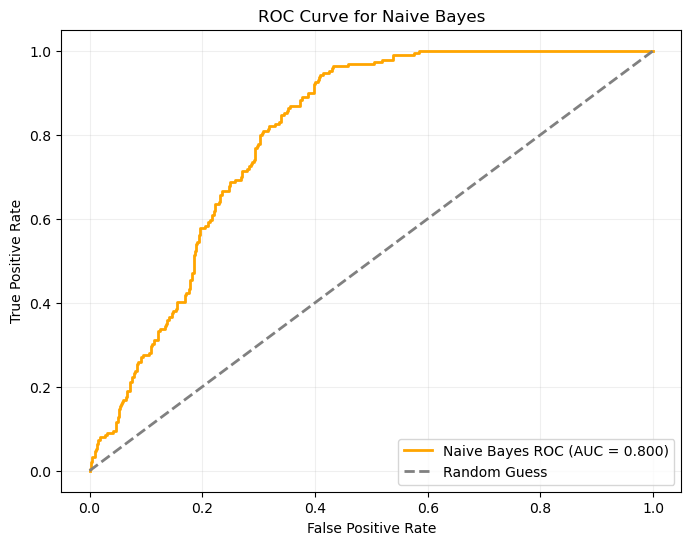

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Step 1: Get Prediction Probabilities ---
# We get the probabilities for the positive class (1) from the trained Naive Bayes model
y_pred_proba_nb = nb_clf.predict_proba(X_test)[:, 1]

# --- Step 2: Calculate ROC and AUC ---
fpr, tpr, _ = roc_curve(y_test_class, y_pred_proba_nb)
auc_nb = roc_auc_score(y_test_class, y_pred_proba_nb)

# --- Step 3: Plot the ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'Naive Bayes ROC (AUC = {auc_nb:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

In [27]:
import pickle

# Save the best KNN model
with open("knn_model.pkl", "wb") as file:
    pickle.dump(best_knn_model, file)

print("✅ KNN model has been saved as knn_model.pkl")


✅ KNN model has been saved as knn_model.pkl


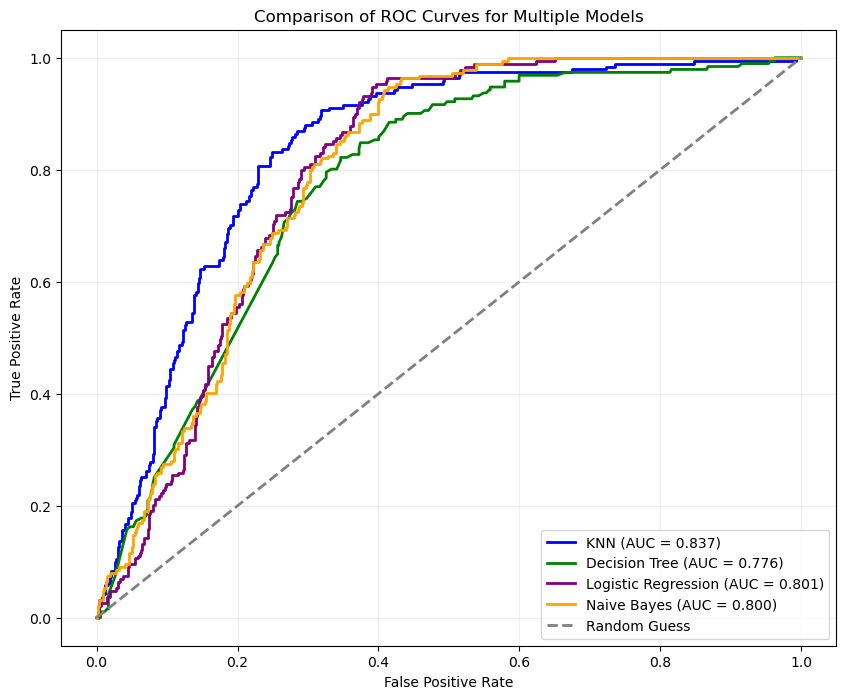

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Step 1: Define binary classes ---
threshold = 10
y_test_binary = (y_test >= threshold).astype(int)  # For regression models like KNN and DT
# Assuming y_test_class is already binary for LR and NB
# If not, convert similarly: y_test_class = (y_test >= threshold).astype(int)

# --- Step 2: Get prediction scores/probabilities ---
# KNN
y_pred_scores_knn = y_pred  # raw predictions from KNN regressor
fpr_knn, tpr_knn, _ = roc_curve(y_test_binary, y_pred_scores_knn)
auc_knn = roc_auc_score(y_test_binary, y_pred_scores_knn)

# Decision Tree
y_pred_scores_dt = y_pred_best_dt  # raw predictions from tuned DT regressor
fpr_dt, tpr_dt, _ = roc_curve(y_test_binary, y_pred_scores_dt)
auc_dt = roc_auc_score(y_test_binary, y_pred_scores_dt)

# Logistic Regression
y_pred_proba_lr = log_reg.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test_class, y_pred_proba_lr)
auc_lr = roc_auc_score(y_test_class, y_pred_proba_lr)

# Naive Bayes
y_pred_proba_nb = nb_clf.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test_class, y_pred_proba_nb)
auc_nb = roc_auc_score(y_test_class, y_pred_proba_nb)

# --- Step 3: Plot all ROC curves together ---
plt.figure(figsize=(10, 8))

plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN (AUC = {auc_knn:.3f})')
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label=f'Decision Tree (AUC = {auc_dt:.3f})')
plt.plot(fpr_lr, tpr_lr, color='purple', lw=2, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_nb, tpr_nb, color='orange', lw=2, label=f'Naive Bayes (AUC = {auc_nb:.3f})')

# Random guess line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves for Multiple Models')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()


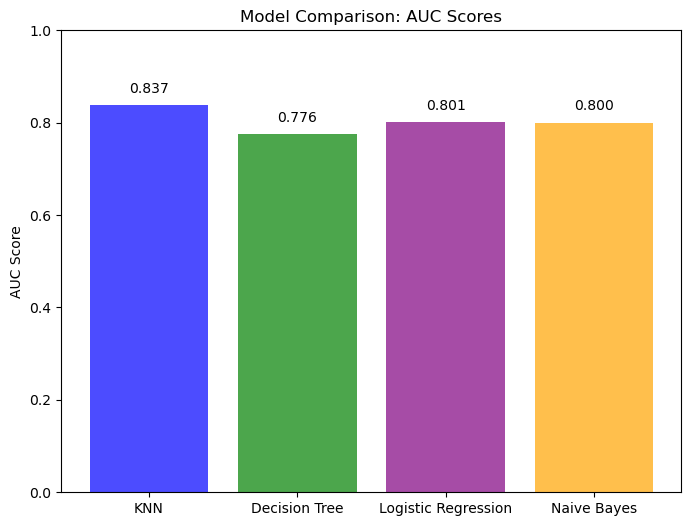

In [29]:
import matplotlib.pyplot as plt

# Example metrics (replace with your actual values)
# If you want accuracy: replace with accuracy scores
# If you want AUC: use the auc values calculated before
metrics = {
    'KNN': auc_knn,  # or accuracy_knn
    'Decision Tree': auc_dt,
    'Logistic Regression': auc_lr,
    'Naive Bayes': auc_nb
}

# --- Step 1: Prepare data ---
models = list(metrics.keys())
scores = list(metrics.values())

# --- Step 2: Plot bar chart ---
plt.figure(figsize=(8,6))
bars = plt.bar(models, scores, color=['blue', 'green', 'purple', 'orange'], alpha=0.7)
plt.ylim(0, 1)  # since AUC and accuracy are between 0 and 1
plt.ylabel('AUC Score')  # or 'Accuracy'
plt.title('Model Comparison: AUC Scores')

# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, f'{height:.3f}', ha='center', va='bottom')

plt.show()


In [1]:
df

NameError: name 'df' is not defined